# 🗺️ Clasificación de Predios que Requieren Actualización de Zonas Homogéneas

Este notebook entrena cuatro modelos clásicos de clasificación binaria para detectar predios que requieren actualización en las Zonas Homogéneas (ZH).

Incluye:
- Carga del dataset construido a partir de shapefiles
- Imputación de NaN
- Escalado
- Entrenamiento de modelos
- Curvas ROC
- Matriz de confusión del mejor modelo
- **Validación con 5 splits diferentes (lo que pide el profesor)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import clone

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (6,4)

## 1. Cargar dataset

In [2]:
df = pd.read_csv('../Datasets/processed/predios_multizh_FULL.csv')
df.shape, df.head()

((82360, 10),
        UID_PREDIO  area_predio  perim_predio  compactness  PRM_PROVIN  \
 0  2010100001820M  1453.438929    297.853900     0.205873         2.0   
 1  20101000022800   403.580921     89.008279     0.640147         2.0   
 2  2010100002480M  1293.693771    176.763001     0.520306         2.0   
 3  2010100002860M   755.305891    112.402487     0.751244         2.0   
 4  2010100003180M   432.587673     86.409932     0.728042         2.0   
 
    PRM_CANTON  PRM_DISTRI  USO  n_zh_unicas  debe_actualizarse  
 0         1.0         1.0    0            2                  1  
 1         1.0         1.0    0            1                  0  
 2         1.0         1.0    0            1                  0  
 3         1.0         1.0    0            3                  1  
 4         1.0         1.0    0            1                  0  )

In [3]:
df['debe_actualizarse'].value_counts(), df.isna().sum().sort_values(ascending=False).head(10)

(debe_actualizarse
 0    67706
 1    14654
 Name: count, dtype: int64,
 PRM_PROVIN           1
 PRM_CANTON           1
 PRM_DISTRI           1
 UID_PREDIO           0
 area_predio          0
 compactness          0
 perim_predio         0
 USO                  0
 n_zh_unicas          0
 debe_actualizarse    0
 dtype: int64)

## 2. Definir X e y

In [4]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

drop_cols = ['debe_actualizarse']
for col in ['PREDIO', 'n_zh_unicas']:
    if col in num_cols:
        drop_cols.append(col)

feature_cols = [c for c in num_cols if c not in drop_cols]
feature_cols

['area_predio',
 'perim_predio',
 'compactness',
 'PRM_PROVIN',
 'PRM_CANTON',
 'PRM_DISTRI',
 'USO']

In [5]:
X = df[feature_cols].copy()
y = df['debe_actualizarse'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((65888, 7), (16472, 7))

## 3. Imputación de NaN + Escalado

In [6]:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_imp)
X_test_s = scaler.transform(X_test_imp)

## 4. Modelos

In [7]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=15),
    'MLP': MLPClassifier(hidden_layer_sizes=(32,16), max_iter=500, random_state=42)
}

models

{'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=2000),
 'DecisionTree': DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=42),
 'KNN': KNeighborsClassifier(n_neighbors=15),
 'MLP': MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=42)}

## 5. Entrenamiento en un solo split

In [8]:
results = []
probas = {}

for name, clf in models.items():
    print(f"Entrenando: {name}")

    if name in ['KNN','LogisticRegression','MLP']:
        clf.fit(X_train_s, y_train)
        y_pred = clf.predict(X_test_s)
        y_proba = clf.predict_proba(X_test_s)[:,1]
    else:
        clf.fit(X_train_imp, y_train)
        y_pred = clf.predict(X_test_imp)
        y_proba = clf.predict_proba(X_test_imp)[:,1]

    results.append({
        'modelo': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

    probas[name] = y_proba

results_zh = pd.DataFrame(results).sort_values(by='f1', ascending=False)
results_zh

Entrenando: LogisticRegression
Entrenando: DecisionTree
Entrenando: KNN
Entrenando: MLP


,modelo,accuracy,precision,recall,f1,roc_auc
1,DecisionTree,0.618018,0.265588,0.649608,0.377030,0.689085
0,LogisticRegression,0.736098,0.313978,0.407711,0.354757,0.644839
2,KNN,0.825886,0.540025,0.145002,0.228618,0.696650
3,MLP,0.829650,0.631579,0.102354,0.176160,0.704844


## 6. Curvas ROC

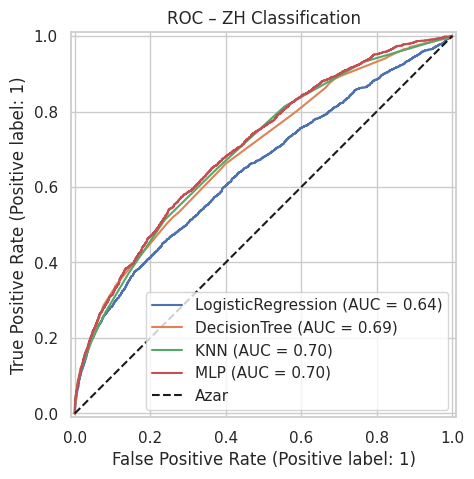

In [9]:
plt.figure(figsize=(7,5))
for name, y_proba in probas.items():
    RocCurveDisplay.from_predictions(y_test, y_proba, name=name, ax=plt.gca())

plt.plot([0,1],[0,1],'k--',label='Azar')
plt.title('ROC – ZH Classification')
plt.legend()
plt.show()

## 7. Matriz de Confusión del mejor modelo

In [10]:
best_name = results_zh.iloc[0]['modelo']
best_name

'DecisionTree'

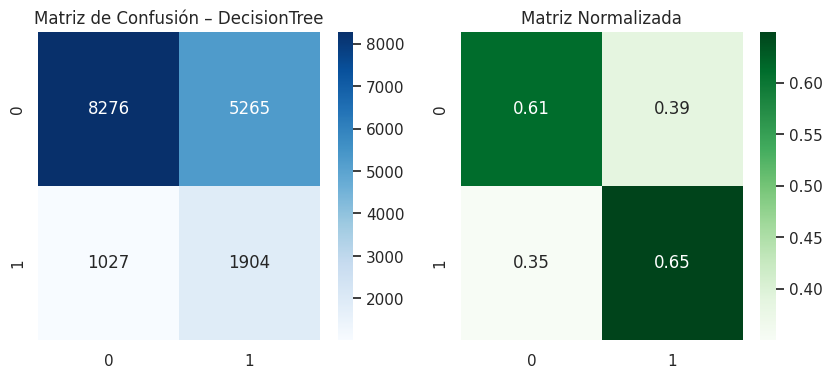

In [11]:
best_clf = models[best_name]

if best_name in ['KNN','LogisticRegression','MLP']:
    best_clf.fit(X_train_s, y_train)
    y_pred_best = best_clf.predict(X_test_s)
else:
    best_clf.fit(X_train_imp, y_train)
    y_pred_best = best_clf.predict(X_test_imp)

cm = confusion_matrix(y_test, y_pred_best)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax[1])
ax[0].set_title(f"Matriz de Confusión – {best_name}")
ax[1].set_title('Matriz Normalizada')
plt.show()

## 8. Validación con 5 splits (lo que pide el profesor)

In [12]:
SEEDS = [10,20,30,40,50]
rows = []

for seed in SEEDS:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )

    # Imputación por split
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)

    # Escalado
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train_imp)
    X_test_s = scaler.transform(X_test_imp)

    for name, base_model in models.items():
        clf = clone(base_model)

        if name in ['KNN','LogisticRegression','MLP']:
            clf.fit(X_train_s, y_train)
            y_pred = clf.predict(X_test_s)
            y_proba = clf.predict_proba(X_test_s)[:,1]
        else:
            clf.fit(X_train_imp, y_train)
            y_pred = clf.predict(X_test_imp)
            y_proba = clf.predict_proba(X_test_imp)[:,1]

        rows.append({
            'modelo': name,
            'seed': seed,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_test, y_proba)
        })

df_splits_zh = pd.DataFrame(rows)
summary_zh = df_splits_zh.groupby('modelo').agg(['mean','std'])
summary_zh

seed             accuracy           precision            \
                    mean        std      mean       std      mean       std   
modelo                                                                        
DecisionTree        30.0  15.811388  0.704395  0.039297  0.304495  0.021319   
KNN                 30.0  15.811388  0.827076  0.001281  0.553458  0.014255   
LogisticRegression  30.0  15.811388  0.735017  0.002844  0.309874  0.004040   
MLP                 30.0  15.811388  0.828363  0.000445  0.617338  0.017120   

                      recall                  f1             roc_auc            
                        mean       std      mean       std      mean       std  
modelo                                                                          
DecisionTree        0.500444  0.058526  0.376293  0.006119  0.681043  0.002560  
KNN                 0.146366  0.004891  0.231468  0.006594  0.696081  0.003108  
LogisticRegression  0.398567  0.006977  0.348646  0.004241  0.640354  0.002526  
MLP                 0.094166  0.010697  0.163131  0.015645  0.690466  0.005379